In [2]:
import sys
import bs4 as bs
import urllib.request
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import lxml
import seaborn as sns
import sktime
from kats.consts import TimeSeriesData

### Collecting the flow data of the Cheat River from the Albright Gauge # 03070260

### Things I want to investigate:
* How many times a year does the Albright gauge read over 20,000 cfs
* Can I predict Albright gauge levels from upstream gauges
    * Can I create a machine learning model that will account for change in level and transmit that downstream

In [67]:
source = urllib.request.urlopen('https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml,2.0&sites=03070260&startDT'
    '=2018-01-01T00:00-0500&endDT=2021-12-31T23:59-0500&parameterCd=00060&siteType=ST&siteStatus=all').read()
soup = bs.BeautifulSoup(source, 'lxml')

# There appears to be a bottleneck so I had to do this in batches to achieve a sample from 2010 - 2021

In [68]:
# Setting up the variable to catch the data
cfs = []
timestamp = []

In [69]:
# gatering the cfs and timestamp data
def acquire_data():
    for wml2 in soup.find_all('wml2:value'):
      cfs.append(float(wml2.string))
    for wml2 in soup.find_all('wml2:time'):
      timestamp.append(wml2.string)

    return cfs, timestamp

In [ ]:
# Collecting the data
cfs, timestamp = acquire_data()

In [ ]:
cfs[:10], timestamp[:10]

In [ ]:
data_dict = {"timestamp":timestamp, "CFS":cfs}


In [ ]:
df_2018 = pd.DataFrame(data_dict)
df_2018.head()

In [ ]:
df_2018.tail()

In [ ]:
data_2014 = {"timestamp":timestamp, "CFS":cfs}
df_2014 = pd.DataFrame(data_2014)
df_2014.head()

In [ ]:
data_2010 = {"timestamp":timestamp, "CFS":cfs}
df_2010 = pd.DataFrame(data_2010)
df_2010.head()

In [ ]:
big_df = pd.concat([df_2010, df_2014, df_2018])
big_df.head(), big_df.tail()

### I will save the data, and use that from here on out - since collecting is a bit of a tedious chore 

This saved csv is only the Albright gauge information.

In [ ]:
big_df.to_csv("2010-2022_alley_cfs.csv", index=False)

In [3]:
big_df = pd.read_csv("2010-2022_alley_cfs.csv")

In [4]:
big_df.shape

(342712, 2)

In [5]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342712 entries, 0 to 342711
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  342712 non-null  object 
 1   CFS        342712 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.2+ MB


In [6]:
big_df.isna().sum()

timestamp    0
CFS          0
dtype: int64

In [7]:
big_df.describe()

,CFS
count,342712.000000
mean,2698.418304
std,3446.954480
min,52.000000
25%,744.000000
50%,1640.000000
75%,3320.000000
max,49800.000000


In [8]:
big_df["CFS"].sum()

924780333.8

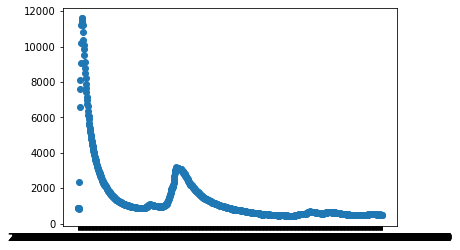

In [9]:
fig, ax = plt.subplots()
ax.scatter(big_df["timestamp"][:1000], big_df["CFS"][:1000])

<AxesSubplot:ylabel='Frequency'>

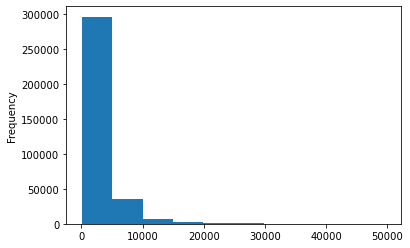

In [13]:
big_df["CFS"].plot.hist()

In [14]:
big_df.timestamp.dtype

dtype('O')

In [15]:
big_df.head()

,timestamp,CFS
0,2010-10-01T00:00:00-04:00,890.0
1,2010-10-01T00:30:00-04:00,875.0
2,2010-10-01T01:00:00-04:00,890.0
3,2010-10-01T01:30:00-04:00,868.0
4,2010-10-01T02:00:00-04:00,861.0


## Parse out timestamp

I will do this by importing the csv data and parse dates vis timestamp column

In [16]:
df = pd.read_csv("2010-2022_alley_cfs.csv",
                low_memory=False)

In [17]:
df.timestamp.dtype

dtype('O')

In [18]:
df.head()

,timestamp,CFS
0,2010-10-01T00:00:00-04:00,890.0
1,2010-10-01T00:30:00-04:00,875.0
2,2010-10-01T01:00:00-04:00,890.0
3,2010-10-01T01:30:00-04:00,868.0
4,2010-10-01T02:00:00-04:00,861.0


In [19]:
df.sort_values(by=["timestamp"], inplace=True, ascending=True)
df.timestamp.head()

0    2010-10-01T00:00:00-04:00
1    2010-10-01T00:30:00-04:00
2    2010-10-01T01:00:00-04:00
3    2010-10-01T01:30:00-04:00
4    2010-10-01T02:00:00-04:00
Name: timestamp, dtype: object

In [20]:
df_tmp = df.copy()

### I realize now, that the parse dates import did not work

I will try another method

In [21]:
df_tmp["timestamp"] = pd.to_datetime(df_tmp["timestamp"].str.slice(stop=19), format='%Y-%m-%dT%H:%M:%S', utc=True)

In [22]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342712 entries, 0 to 342711
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  342712 non-null  datetime64[ns, UTC]
 1   CFS        342712 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 7.8 MB


In [23]:
df_tmp.head()

,timestamp,CFS
0,2010-10-01 00:00:00+00:00,890.0
1,2010-10-01 00:30:00+00:00,875.0
2,2010-10-01 01:00:00+00:00,890.0
3,2010-10-01 01:30:00+00:00,868.0
4,2010-10-01 02:00:00+00:00,861.0


In [24]:
df_tmp["Year"] = df_tmp["timestamp"].dt.year
df_tmp["Month"] = df_tmp["timestamp"].dt.month
df_tmp["Day"] = df_tmp["timestamp"].dt.day
df_tmp["DayofWeek"] = df_tmp["timestamp"].dt.dayofweek
df_tmp["DayofYear"] = df_tmp["timestamp"].dt.dayofyear

In [25]:
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274


In [26]:
df_tmp["Hour"] = df_tmp["timestamp"].dt.hour

In [27]:
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2


In [28]:
df_tmp["Minute"] = df_tmp["timestamp"].dt.minute
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0,0
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0,30
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1,0
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1,30
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2,0


In [29]:
(df_tmp["CFS"]>20000).value_counts()

False    340475
True       2237
Name: CFS, dtype: int64

### I want to find how many days a year the cfs is over 20k for every year

In [30]:
df_tmp["Flood"] = df_tmp["CFS"]>20000
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0,0,False
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0,30,False
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1,0,False
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1,30,False
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2,0,False


In [31]:
(df_tmp["Flood"]==True).value_counts()

False    340475
True       2237
Name: Flood, dtype: int64

So a total number of entries of flooding = 2237

In [32]:
occur = df_tmp.groupby(["Flood", "Year", "DayofYear"]).size()
occur

Flood  Year  DayofYear
False  2010  274          48
             275          48
             276          48
             277          48
             278          48
                          ..
True   2021  59           28
             60           96
             61           46
             244          38
             245           8
Length: 4074, dtype: int64

In [33]:
pd.crosstab(df_tmp.Flood, df_tmp.Year)

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Flood,,,,,,,,,,,,,
False,3928,16838,17518,33292,33627,31034,32516,34204,33454,34213,35015,34816,20
True,6,150,45,257,146,347,14,131,602,209,114,216,0


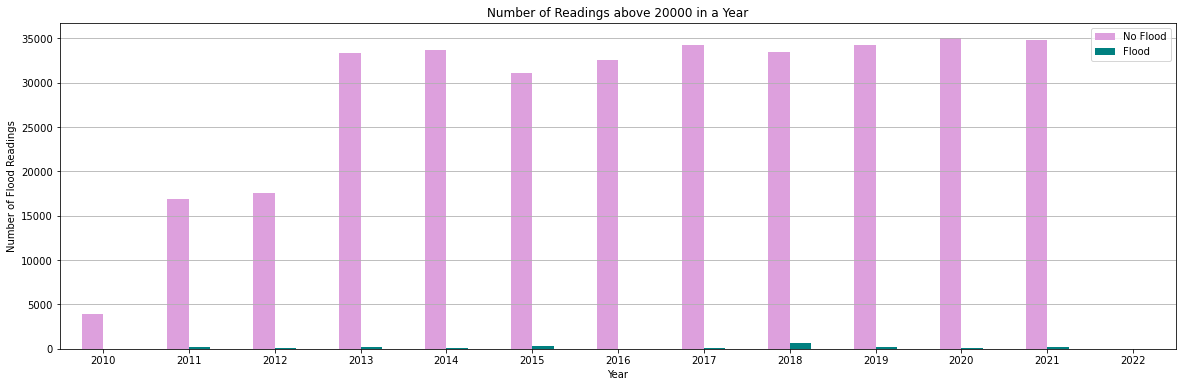

In [34]:
pd.crosstab(df_tmp.Year, df_tmp.Flood).plot(kind="bar",
                                    figsize=(20, 6),
                                    color=["plum", "teal"])
plt.title("Number of Readings above 20000 in a Year")
plt.xlabel("Year")
plt.ylabel("Number of Flood Readings")
plt.legend(["No Flood", "Flood"])
plt.xticks(rotation=0)
plt.grid(linestyle='-', axis='y');

In [35]:
df_tmp["Flood"] = df_tmp["Flood"].astype(int)
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0,0,0
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0,30,0
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1,0,0
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1,30,0
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2,0,0


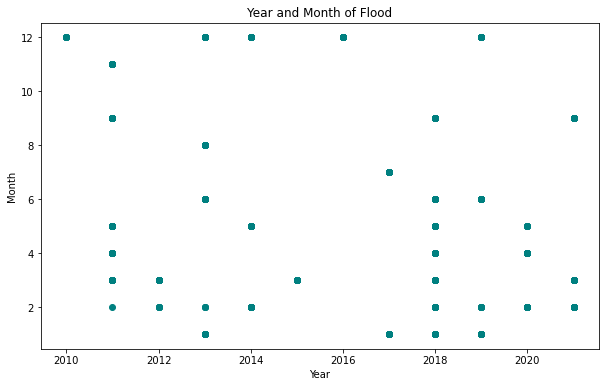

In [36]:
plt.figure(figsize=(10, 6))

# Scatter with positive examples
plt.scatter(df_tmp.Year[df_tmp.Flood==1],
            df_tmp.Month[df_tmp.Flood==1],
            color="teal")

# Add some helpful info
plt.title("Year and Month of Flood")
plt.xlabel("Year")
plt.ylabel("Month");

In [37]:
df_tmp.groupby(["Month", "Flood"]).count()

timestamp    CFS   Year    Day  DayofWeek  DayofYear   Hour  \
Month Flood                                                                
1     0          22247  22247  22247  22247      22247      22247  22247   
      1            206    206    206    206        206        206    206   
2     0          23523  23523  23523  23523      23523      23523  23523   
      1            359    359    359    359        359        359    359   
3     0          28948  28948  28948  28948      28948      28948  28948   
      1            661    661    661    661        661        661    661   
4     0          28381  28381  28381  28381      28381      28381  28381   
      1            118    118    118    118        118        118    118   
5     0          29578  29578  29578  29578      29578      29578  29578   
      1            162    162    162    162        162        162    162   
6     0          28590  28590  28590  28590      28590      28590  28590   
      1            111    111    111    111        111        111    111   
7     0          29646  29646  29646  29646      29646      29646  29646   
      1            107    107    107    107        107        107    107   
8     0          29619  29619  29619  29619      29619      29619  29619   
      1             88     88     88     88         88         88     88   
9     0          28375  28375  28375  28375      28375      28375  28375   
      1            146    146    146    146        146        146    146   
10    0          31126  31126  31126  31126      31126      31126  31126   
11    0          30236  30236  30236  30236      30236      30236  30236   
      1             38     38     38     38         38         38     38   
12    0          30206  30206  30206  30206      30206      30206  30206   
      1            241    241    241    241        241        241    241   

             Minute  
Month Flood          
1     0       22247  
      1         206  
2     0       23523  
      1         359  
3     0       28948  
      1         661  
4     0       28381  
      1         118  
5     0       29578  
      1         162  
6     0       28590  
      1         111  
7     0       29646  
      1         107  
8     0       29619  
      1          88  
9     0       28375  
      1         146  
10    0       31126  
11    0       30236  
      1          38  
12    0       30206  
      1         241

In [38]:
df_tmp.describe()

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood
count,342712.000000,342712.000000,342712.000000,342712.000000,342712.000000,342712.00000,342712.000000,342712.000000,342712.000000
mean,2698.418304,2016.417666,6.729265,15.747779,2.993543,189.39722,11.499396,21.642575,0.006527
std,3446.954480,3.043695,3.385327,8.802016,2.001589,103.48131,6.925035,16.753539,0.080528
min,52.000000,2010.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000
25%,744.000000,2014.000000,4.000000,8.000000,1.000000,101.00000,5.000000,0.000000,0.000000
50%,1640.000000,2017.000000,7.000000,16.000000,3.000000,191.00000,11.000000,30.000000,0.000000
75%,3320.000000,2019.000000,10.000000,23.000000,5.000000,280.00000,18.000000,30.000000,0.000000
max,49800.000000,2022.000000,12.000000,31.000000,6.000000,366.00000,23.000000,45.000000,1.000000


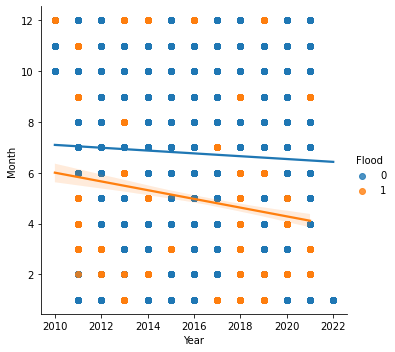

In [39]:
g = sns.lmplot(x="Year", y="Month", hue="Flood", data=df_tmp)

In [40]:
df_tmp["Alley"] = (df_tmp["CFS"]>500) & (df_tmp["CFS"]<2000)
df_tmp.head()

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0,0,0,True
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0,30,0,True
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1,0,0,True
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1,30,0,True
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2,0,0,True


In [41]:
df_tmp["Alley"].value_counts()

False    204003
True     138709
Name: Alley, dtype: int64

In [42]:
# Make a DataFrame of single day values that are the mean values for that day
single_day_value = df_tmp.groupby(pd.Grouper(key="timestamp", freq="1d")).mean()
single_day_value.head(5), df_tmp.head(5)

(                                   CFS    Year  Month  Day  DayofWeek  \
 timestamp                                                               
 2010-10-01 00:00:00+00:00  6934.250000  2010.0   10.0  1.0        4.0   
 2010-10-02 00:00:00+00:00  2940.208333  2010.0   10.0  2.0        5.0   
 2010-10-03 00:00:00+00:00  1501.250000  2010.0   10.0  3.0        6.0   
 2010-10-04 00:00:00+00:00  1024.270833  2010.0   10.0  4.0        0.0   
 2010-10-05 00:00:00+00:00   937.687500  2010.0   10.0  5.0        1.0   
 
                            DayofYear  Hour  Minute  Flood     Alley  
 timestamp                                                            
 2010-10-01 00:00:00+00:00      274.0  11.5    15.0    0.0  0.104167  
 2010-10-02 00:00:00+00:00      275.0  11.5    15.0    0.0  0.020833  
 2010-10-03 00:00:00+00:00      276.0  11.5    15.0    0.0  1.000000  
 2010-10-04 00:00:00+00:00      277.0  11.5    15.0    0.0  1.000000  
 2010-10-05 00:00:00+00:00      278.0  11.5    15.0   

In [43]:
single_day_value[:5]

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
timestamp,,,,,,,,,,
2010-10-01 00:00:00+00:00,6934.250000,2010.0,10.0,1.0,4.0,274.0,11.5,15.0,0.0,0.104167
2010-10-02 00:00:00+00:00,2940.208333,2010.0,10.0,2.0,5.0,275.0,11.5,15.0,0.0,0.020833
2010-10-03 00:00:00+00:00,1501.250000,2010.0,10.0,3.0,6.0,276.0,11.5,15.0,0.0,1.000000
2010-10-04 00:00:00+00:00,1024.270833,2010.0,10.0,4.0,0.0,277.0,11.5,15.0,0.0,1.000000
2010-10-05 00:00:00+00:00,937.687500,2010.0,10.0,5.0,1.0,278.0,11.5,15.0,0.0,1.000000


In [44]:
df_tmp[:20]

,timestamp,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
0,2010-10-01 00:00:00+00:00,890.0,2010,10,1,4,274,0,0,0,True
1,2010-10-01 00:30:00+00:00,875.0,2010,10,1,4,274,0,30,0,True
2,2010-10-01 01:00:00+00:00,890.0,2010,10,1,4,274,1,0,0,True
3,2010-10-01 01:30:00+00:00,868.0,2010,10,1,4,274,1,30,0,True
4,2010-10-01 02:00:00+00:00,861.0,2010,10,1,4,274,2,0,0,True
5,2010-10-01 02:30:00+00:00,2340.0,2010,10,1,4,274,2,30,0,False
6,2010-10-01 03:00:00+00:00,6600.0,2010,10,1,4,274,3,0,0,False
7,2010-10-01 03:30:00+00:00,7630.0,2010,10,1,4,274,3,30,0,False
8,2010-10-01 04:00:00+00:00,8110.0,2010,10,1,4,274,4,0,0,False
9,2010-10-01 04:30:00+00:00,9060.0,2010,10,1,4,274,4,30,0,False


In [45]:
single_day_value["Flood"].value_counts()

0.000000    3941
0.104167       4
0.093750       3
0.468750       3
0.020833       3
0.833333       2
0.114583       2
0.302083       2
0.062500       2
0.843750       2
0.260417       2
0.416667       2
0.083333       2
0.645833       2
0.697917       2
0.885417       1
0.166667       1
0.520833       1
0.343750       1
0.604167       1
0.135417       1
0.479167       1
1.000000       1
0.708333       1
0.864583       1
0.312500       1
0.041667       1
0.968750       1
0.291667       1
0.156250       1
0.458333       1
0.437500       1
0.677083       1
0.333333       1
0.208333       1
0.791667       1
0.187500       1
0.820896       1
0.031250       1
0.010417       1
0.916667       1
0.739583       1
0.364583       1
0.583333       1
0.125000       1
0.239583       1
0.052083       1
0.250000       1
0.395833       1
Name: Flood, dtype: int64

In [46]:
single_day_value["Flood"] = (single_day_value["Flood"]>0)
single_day_value["Flood"].value_counts()

False    4044
True       67
Name: Flood, dtype: int64

In [47]:
single_day_value["Flood"].astype(int)
single_day_value["Flood"].value_counts()

False    4044
True       67
Name: Flood, dtype: int64

<AxesSubplot:xlabel='Year', ylabel='Number of Days with CFS value over 20000'>

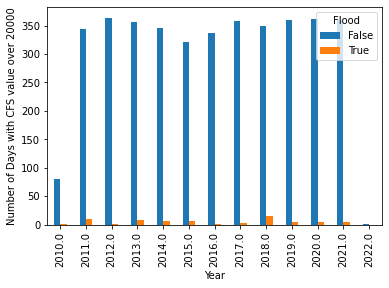

In [48]:
pd.crosstab(single_day_value.Year, single_day_value.Flood).plot(kind="bar",
                                             xlabel="Year",
                                             ylabel="Number of Days with CFS value over 20000")

In [49]:
flooded = single_day_value[single_day_value["Flood"]==True]
flooded.head()

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
timestamp,,,,,,,,,,
2010-12-01 00:00:00+00:00,10345.208333,2010.0,12.0,1.0,2.0,335.0,11.5,15.0,True,0.0
2011-02-28 00:00:00+00:00,9645.208333,2011.0,2.0,28.0,0.0,59.0,11.5,15.0,True,0.0
2011-03-01 00:00:00+00:00,21370.833333,2011.0,3.0,1.0,1.0,60.0,11.5,15.0,True,0.0
2011-03-11 00:00:00+00:00,17900.000000,2011.0,3.0,11.0,4.0,70.0,11.5,15.0,True,0.0
2011-04-13 00:00:00+00:00,15110.833333,2011.0,4.0,13.0,2.0,103.0,11.5,15.0,True,0.0


In [50]:
flooded.groupby(pd.Grouper(key="Year")).sum()

,CFS,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
Year,,,,,,,,,
2010.0,10345.208333,12.0,1.0,2.0,335.0,11.500000,15.000000,1,0.000000
2011.0,159572.708333,49.0,168.0,19.0,1344.0,115.000000,150.000000,10,0.000000
2012.0,30451.458333,5.0,30.0,5.0,121.0,23.000000,30.000000,2,0.000000
2013.0,144958.048818,37.0,128.0,27.0,1007.0,94.052239,161.977612,8,0.447917
2014.0,93045.416667,38.0,57.0,25.0,1027.0,69.000000,135.000000,6,0.000000
2015.0,137817.916667,18.0,61.0,21.0,415.0,69.000000,135.000000,6,0.000000
2016.0,27094.895833,24.0,37.0,6.0,707.0,23.000000,45.000000,2,0.000000
2017.0,68966.354167,15.0,63.0,13.0,425.0,34.500000,67.500000,3,0.000000
2018.0,273988.854167,61.0,238.0,50.0,1626.0,172.500000,337.500000,15,0.395833


In [51]:
df_tmp.groupby(pd.Grouper(key="Year")).sum()["Flood"]

Year
2010      6
2011    150
2012     45
2013    257
2014    146
2015    347
2016     14
2017    131
2018    602
2019    209
2020    114
2021    216
2022      0
Name: Flood, dtype: int64

In [52]:
single_day_value.groupby(pd.Grouper(key="Year")).sum()

,CFS,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
Year,,,,,,,,,
2010.0,1.198844e+05,892.0,1236.0,249.0,25833.0,942.667419,1230.638298,1,53.633152
2011.0,1.223607e+06,2330.0,5581.0,1067.0,65395.0,4071.209972,5310.638298,10,136.854167
2012.0,7.720079e+05,2384.0,5767.0,1098.0,67161.0,4209.222923,5490.319149,2,123.250000
2013.0,1.067819e+06,2382.0,5738.0,1093.0,66795.0,4199.683544,7984.262834,8,169.033514
2014.0,7.819737e+05,2365.0,5479.0,1048.0,66412.0,4047.886231,7921.525619,6,166.768969
2015.0,8.306498e+05,2323.0,5114.0,958.0,65523.0,3760.619462,7357.736842,6,123.114583
2016.0,7.733746e+05,2341.0,5391.0,1022.0,66295.0,3897.431640,7628.214286,2,117.557518
2017.0,9.565430e+05,2378.0,5700.0,1089.0,66757.0,4147.466651,8196.620235,3,147.971591
2018.0,1.530278e+06,2382.0,5738.0,1092.0,66795.0,4208.340228,8464.569687,15,124.270161


In [53]:
for_graph = flooded.groupby(pd.Grouper(key="Year")).count()
for_graph.head()

,CFS,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
Year,,,,,,,,,
2010.0,1,1,1,1,1,1,1,1,1
2011.0,10,10,10,10,10,10,10,10,10
2012.0,2,2,2,2,2,2,2,2,2
2013.0,8,8,8,8,8,8,8,8,8
2014.0,6,6,6,6,6,6,6,6,6


In [54]:
for_graph.reset_index(inplace=True)
for_graph.head()

,Year,CFS,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
0,2010.0,1,1,1,1,1,1,1,1,1
1,2011.0,10,10,10,10,10,10,10,10,10
2,2012.0,2,2,2,2,2,2,2,2,2
3,2013.0,8,8,8,8,8,8,8,8,8
4,2014.0,6,6,6,6,6,6,6,6,6


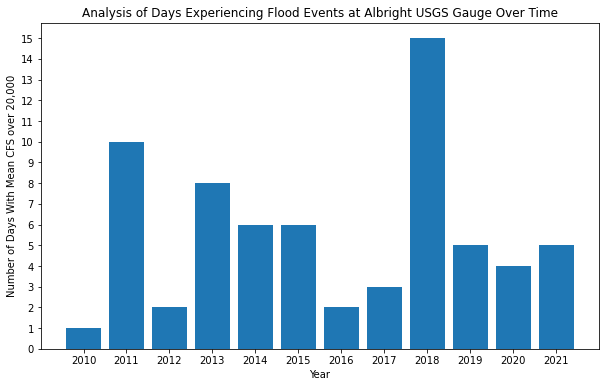

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(for_graph.Year, for_graph.Flood)
plt.xlabel("Year")
plt.ylabel("Number of Days With Mean CFS over 20,000")
plt.title("Analysis of Days Experiencing Flood Events at Albright USGS Gauge Over Time")
plt.xticks(np.arange(2010, 2022, step=1))
plt.yticks(np.arange(0, 16, step=1));

In [56]:
# I am trying to figure out how to make the above graph from the original DataFrame
#fig, ax = plt.subplots(figsize=(10, 6))
#ax.bar(single_day_value["Year"], single_day_value.groupby(["Year"], squeeze=True).count()["Flood"])
#plt.xlabel("Year")
#plt.ylabel("Number of Days With Mean CFS over 20,000")
#plt.title("Analysis of Days Experiencing Flood Events at Albright USGS Gauge Over Time")
#plt.xticks(np.arange(2010, 2022, step=1))
#plt.yticks(np.arange(0, 16, step=1));

### I am curious about 2018!

Let's investigate that year

In [57]:
albright_2018 = single_day_value[single_day_value["Year"]==2018]
albright_2018

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
timestamp,,,,,,,,,,
2018-01-01 00:00:00+00:00,1028.083333,2018.0,1.0,1.0,0.0,1.0,12.0,45.0,False,1.0
2018-01-02 00:00:00+00:00,907.083333,2018.0,1.0,2.0,1.0,2.0,12.0,45.0,False,1.0
2018-01-03 00:00:00+00:00,897.500000,2018.0,1.0,3.0,2.0,3.0,12.0,45.0,False,1.0
2018-01-04 00:00:00+00:00,996.750000,2018.0,1.0,4.0,3.0,4.0,12.0,45.0,False,1.0
2018-01-05 00:00:00+00:00,1107.500000,2018.0,1.0,5.0,4.0,5.0,12.0,45.0,False,1.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00+00:00,2568.333333,2018.0,12.0,27.0,3.0,361.0,11.5,22.5,False,0.0
2018-12-28 00:00:00+00:00,4565.625000,2018.0,12.0,28.0,4.0,362.0,11.5,22.5,False,0.0
2018-12-29 00:00:00+00:00,9941.354167,2018.0,12.0,29.0,5.0,363.0,11.5,22.5,False,0.0


<AxesSubplot:xlabel='timestamp'>

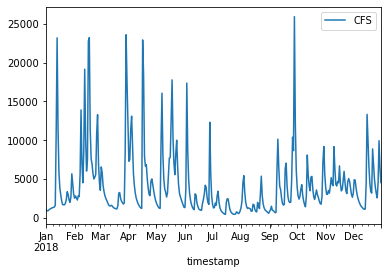

In [58]:
albright_2018.plot(y="CFS")

In [59]:
albright_2018["CFS"].mean()

4192.542033545989

In [60]:
albright_2018.describe()

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Alley
count,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,4192.542034,2018.0,6.526027,15.720548,2.991781,183.000000,11.529699,23.190602,0.340466
std,4161.364803,0.0,3.452584,8.808321,2.006155,105.510663,0.300127,3.855751,0.448878
min,445.364583,2018.0,1.000000,1.000000,0.000000,1.000000,11.080000,22.500000,0.000000
25%,1608.333333,2018.0,4.000000,8.000000,1.000000,92.000000,11.500000,22.500000,0.000000
50%,2918.854167,2018.0,7.000000,16.000000,3.000000,183.000000,11.500000,22.500000,0.000000
75%,5051.145833,2018.0,10.000000,23.000000,5.000000,274.000000,11.500000,22.500000,1.000000
max,25944.791667,2018.0,12.000000,31.000000,6.000000,365.000000,16.977273,45.000000,1.000000


In [61]:
sept_2018 = albright_2018[albright_2018["Month"]==9.0]


In [62]:
sept_2018

,CFS,Year,Month,Day,DayofWeek,DayofYear,Hour,Minute,Flood,Alley
timestamp,,,,,,,,,,
2018-09-01 00:00:00+00:00,825.895833,2018.0,9.0,1.0,5.0,244.0,11.5,22.5,False,1.000000
2018-09-02 00:00:00+00:00,1028.343750,2018.0,9.0,2.0,6.0,245.0,11.5,22.5,False,1.000000
2018-09-03 00:00:00+00:00,1486.458333,2018.0,9.0,3.0,0.0,246.0,11.5,22.5,False,1.000000
2018-09-04 00:00:00+00:00,972.135417,2018.0,9.0,4.0,1.0,247.0,11.5,22.5,False,1.000000
2018-09-05 00:00:00+00:00,939.656250,2018.0,9.0,5.0,2.0,248.0,11.5,22.5,False,1.000000
2018-09-06 00:00:00+00:00,802.729167,2018.0,9.0,6.0,3.0,249.0,11.5,22.5,False,1.000000
2018-09-07 00:00:00+00:00,656.333333,2018.0,9.0,7.0,4.0,250.0,11.5,22.5,False,1.000000
2018-09-08 00:00:00+00:00,686.958333,2018.0,9.0,8.0,5.0,251.0,11.5,22.5,False,1.000000
2018-09-09 00:00:00+00:00,5993.020833,2018.0,9.0,9.0,6.0,252.0,11.5,22.5,False,0.239583


<AxesSubplot:xlabel='Day'>

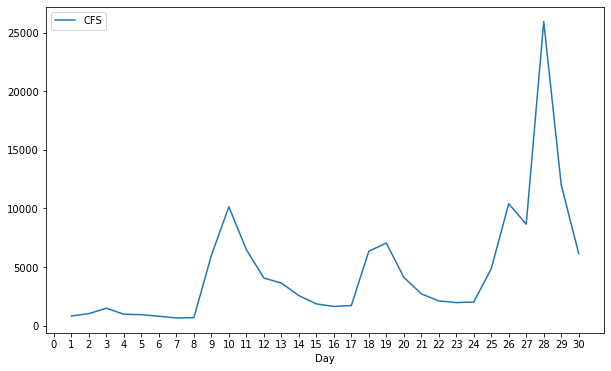

In [63]:
sept_2018.plot(x="Day",
               y="CFS",
              xticks=np.arange(0, 31),
              figsize=(10, 6))

## I want to collect sample data from multiple sites and see what I have to do to fit the different gauge sites together onto the same DataFrame indexed by a single datetime column

Setup the beautiful soup data extraction workflow

In [70]:
# gatering the cfs and timestamp data
def acquire_data():
    for wml2 in soup.find_all('wml2:value'):
      cfs.append(float(wml2.string))
    for wml2 in soup.find_all('wml2:time'):
      timestamp.append(wml2.string)

    return cfs, timestamp

In [71]:
# Create a dictionary of sites and their id numbers
site_list = {"Albright":'03070260',
             "Parsons": '03069500',
             "DryFork": '03065000'
             }

In [72]:
# Create a loop to grab data for multiple sites placing the data in a variable
# called the site name
for i in site_list:
    source = urllib.request.urlopen(f'https://nwis.waterservices.usgs.gov/nwis/iv/?format=waterml,2.0&sites={site_list[i]}&startDT'
    '=2018-01-01T00:00-0500&endDT=2021-12-31T23:59-0500&parameterCd=00060&siteType=ST&siteStatus=all').read()
    soup = bs.BeautifulSoup(source, 'lxml')
    cfs = []
    timestamp = []
    # Collecting the data
    cfs, timestamp = acquire_data()
    # Creating variable name to hold the data
    exec('{KEY} = {VALUE}'.format(KEY = i, VALUE = dict(zip(timestamp, cfs))))
    

In [79]:
Albright['2018-01-01T05:45:00-05:00']

1070.0

In [80]:
Parsons['2018-01-01T05:45:00-05:00']

639.0

In [82]:
DryFork['2018-01-01T05:45:00-05:00']

294.0

The different sites don't have similar time schedules

In [83]:
len(Albright), len(Parsons), len(DryFork)

(138657, 139813, 137613)

In [84]:
df = pd.DataFrame.from_dict(Albright, orient='index')

In [85]:
df

,0
2018-01-01T05:45:00-05:00,1070.0
2018-01-01T07:45:00-05:00,1060.0
2018-01-01T09:45:00-05:00,1040.0
2018-01-01T11:45:00-05:00,1030.0
2018-01-01T13:45:00-05:00,1020.0
...,...
2022-01-01T03:45:00-05:00,4500.0
2022-01-01T04:00:00-05:00,4410.0
2022-01-01T04:15:00-05:00,4450.0
2022-01-01T04:30:00-05:00,4460.0


In [86]:
df["cfs"] = df[0]
df.head()

,0,cfs
2018-01-01T05:45:00-05:00,1070.0,1070.0
2018-01-01T07:45:00-05:00,1060.0,1060.0
2018-01-01T09:45:00-05:00,1040.0,1040.0
2018-01-01T11:45:00-05:00,1030.0,1030.0
2018-01-01T13:45:00-05:00,1020.0,1020.0


In [87]:
df.drop(0, axis=1)

,cfs
2018-01-01T05:45:00-05:00,1070.0
2018-01-01T07:45:00-05:00,1060.0
2018-01-01T09:45:00-05:00,1040.0
2018-01-01T11:45:00-05:00,1030.0
2018-01-01T13:45:00-05:00,1020.0
...,...
2022-01-01T03:45:00-05:00,4500.0
2022-01-01T04:00:00-05:00,4410.0
2022-01-01T04:15:00-05:00,4450.0
2022-01-01T04:30:00-05:00,4460.0


In [88]:
df["Albright"] = df["cfs"]
df.drop("cfs", axis=1, inplace=True)
df.drop(0, axis=1, inplace=True)
df.head()

,Albright
2018-01-01T05:45:00-05:00,1070.0
2018-01-01T07:45:00-05:00,1060.0
2018-01-01T09:45:00-05:00,1040.0
2018-01-01T11:45:00-05:00,1030.0
2018-01-01T13:45:00-05:00,1020.0


In [89]:
df["timestamp"] = df.index
df.head()

,Albright,timestamp
2018-01-01T05:45:00-05:00,1070.0,2018-01-01T05:45:00-05:00
2018-01-01T07:45:00-05:00,1060.0,2018-01-01T07:45:00-05:00
2018-01-01T09:45:00-05:00,1040.0,2018-01-01T09:45:00-05:00
2018-01-01T11:45:00-05:00,1030.0,2018-01-01T11:45:00-05:00
2018-01-01T13:45:00-05:00,1020.0,2018-01-01T13:45:00-05:00


In [90]:
df["Parsons"] = df["timestamp"].map(Parsons)

In [91]:
df.head()

,Albright,timestamp,Parsons
2018-01-01T05:45:00-05:00,1070.0,2018-01-01T05:45:00-05:00,639.0
2018-01-01T07:45:00-05:00,1060.0,2018-01-01T07:45:00-05:00,631.0
2018-01-01T09:45:00-05:00,1040.0,2018-01-01T09:45:00-05:00,624.0
2018-01-01T11:45:00-05:00,1030.0,2018-01-01T11:45:00-05:00,616.0
2018-01-01T13:45:00-05:00,1020.0,2018-01-01T13:45:00-05:00,611.0


In [92]:
Parsons

{'2018-01-01T05:00:00-05:00': 641.0,
 '2018-01-01T05:15:00-05:00': 641.0,
 '2018-01-01T05:30:00-05:00': 640.0,
 '2018-01-01T05:45:00-05:00': 639.0,
 '2018-01-01T06:00:00-05:00': 638.0,
 '2018-01-01T06:15:00-05:00': 637.0,
 '2018-01-01T06:30:00-05:00': 636.0,
 '2018-01-01T06:45:00-05:00': 635.0,
 '2018-01-01T07:00:00-05:00': 634.0,
 '2018-01-01T07:15:00-05:00': 633.0,
 '2018-01-01T07:30:00-05:00': 632.0,
 '2018-01-01T07:45:00-05:00': 631.0,
 '2018-01-01T08:00:00-05:00': 630.0,
 '2018-01-01T08:15:00-05:00': 629.0,
 '2018-01-01T08:30:00-05:00': 628.0,
 '2018-01-01T08:45:00-05:00': 628.0,
 '2018-01-01T09:00:00-05:00': 627.0,
 '2018-01-01T09:15:00-05:00': 626.0,
 '2018-01-01T09:30:00-05:00': 625.0,
 '2018-01-01T09:45:00-05:00': 624.0,
 '2018-01-01T10:00:00-05:00': 623.0,
 '2018-01-01T10:15:00-05:00': 622.0,
 '2018-01-01T10:30:00-05:00': 621.0,
 '2018-01-01T10:45:00-05:00': 620.0,
 '2018-01-01T11:00:00-05:00': 619.0,
 '2018-01-01T11:15:00-05:00': 618.0,
 '2018-01-01T11:30:00-05:00': 617.0,
 

In [93]:
df["DryFork"] = df["timestamp"].map(DryFork)
df.head()

,Albright,timestamp,Parsons,DryFork
2018-01-01T05:45:00-05:00,1070.0,2018-01-01T05:45:00-05:00,639.0,294.0
2018-01-01T07:45:00-05:00,1060.0,2018-01-01T07:45:00-05:00,631.0,290.0
2018-01-01T09:45:00-05:00,1040.0,2018-01-01T09:45:00-05:00,624.0,287.0
2018-01-01T11:45:00-05:00,1030.0,2018-01-01T11:45:00-05:00,616.0,282.0
2018-01-01T13:45:00-05:00,1020.0,2018-01-01T13:45:00-05:00,611.0,278.0


In [94]:
len(df)

138657

In [95]:
df["timestamp"] = pd.to_datetime(df['timestamp'])
df.head()

,Albright,timestamp,Parsons,DryFork
2018-01-01T05:45:00-05:00,1070.0,2018-01-01 05:45:00-05:00,639.0,294.0
2018-01-01T07:45:00-05:00,1060.0,2018-01-01 07:45:00-05:00,631.0,290.0
2018-01-01T09:45:00-05:00,1040.0,2018-01-01 09:45:00-05:00,624.0,287.0
2018-01-01T11:45:00-05:00,1030.0,2018-01-01 11:45:00-05:00,616.0,282.0
2018-01-01T13:45:00-05:00,1020.0,2018-01-01 13:45:00-05:00,611.0,278.0


In [96]:
type(df.index)

pandas.core.indexes.base.Index

In [97]:
df.index = pd.to_datetime(df.index, utc=True)

In [98]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [99]:
df.head()

,Albright,timestamp,Parsons,DryFork
2018-01-01 10:45:00+00:00,1070.0,2018-01-01 05:45:00-05:00,639.0,294.0
2018-01-01 12:45:00+00:00,1060.0,2018-01-01 07:45:00-05:00,631.0,290.0
2018-01-01 14:45:00+00:00,1040.0,2018-01-01 09:45:00-05:00,624.0,287.0
2018-01-01 16:45:00+00:00,1030.0,2018-01-01 11:45:00-05:00,616.0,282.0
2018-01-01 18:45:00+00:00,1020.0,2018-01-01 13:45:00-05:00,611.0,278.0


In [100]:
df.drop("timestamp", axis=1, inplace=True)

In [101]:
df.head()

,Albright,Parsons,DryFork
2018-01-01 10:45:00+00:00,1070.0,639.0,294.0
2018-01-01 12:45:00+00:00,1060.0,631.0,290.0
2018-01-01 14:45:00+00:00,1040.0,624.0,287.0
2018-01-01 16:45:00+00:00,1030.0,616.0,282.0
2018-01-01 18:45:00+00:00,1020.0,611.0,278.0


In [102]:
Albright["2018-01-01T05:45:00-05:00"], Parsons["2018-01-01T05:45:00-05:00"], DryFork["2018-01-01T05:45:00-05:00"]

(1070.0, 639.0, 294.0)

I am going to save the dataframe so I can come back and use this
I think it is setup how I want it

In [103]:
df.to_csv("albright-parsons-dryfork2018-2021.csv")

In [104]:
df.tail()

,Albright,Parsons,DryFork
2022-01-01 08:45:00+00:00,4500.0,2490.0,1220.0
2022-01-01 09:00:00+00:00,4410.0,2460.0,1220.0
2022-01-01 09:15:00+00:00,4450.0,2500.0,1230.0
2022-01-01 09:30:00+00:00,4460.0,2520.0,1230.0
2022-01-01 09:45:00+00:00,4460.0,2530.0,1230.0


In [105]:
# Test the csv
df1 = pd.read_csv('albright-parsons-dryfork2018-2021.csv', index_col=0)
df1.head()

,Albright,Parsons,DryFork
2018-01-01 10:45:00+00:00,1070.0,639.0,294.0
2018-01-01 12:45:00+00:00,1060.0,631.0,290.0
2018-01-01 14:45:00+00:00,1040.0,624.0,287.0
2018-01-01 16:45:00+00:00,1030.0,616.0,282.0
2018-01-01 18:45:00+00:00,1020.0,611.0,278.0


In [106]:
df1.index.name = "Date"

In [107]:
df1.head()

,Albright,Parsons,DryFork
Date,,,
2018-01-01 10:45:00+00:00,1070.0,639.0,294.0
2018-01-01 12:45:00+00:00,1060.0,631.0,290.0
2018-01-01 14:45:00+00:00,1040.0,624.0,287.0
2018-01-01 16:45:00+00:00,1030.0,616.0,282.0
2018-01-01 18:45:00+00:00,1020.0,611.0,278.0


<AxesSubplot:xlabel='Date'>

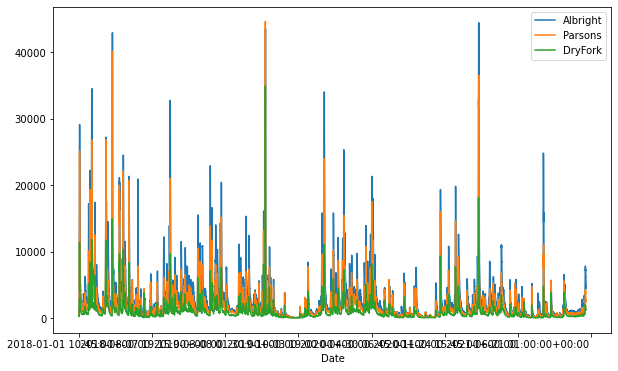

In [108]:
df1.plot(figsize=(10, 6))

In [109]:
# I want to label the index
df1.to_csv("albright-parsons-dryfork2018-2021.csv")

In [110]:
df1.head()

,Albright,Parsons,DryFork
Date,,,
2018-01-01 10:45:00+00:00,1070.0,639.0,294.0
2018-01-01 12:45:00+00:00,1060.0,631.0,290.0
2018-01-01 14:45:00+00:00,1040.0,624.0,287.0
2018-01-01 16:45:00+00:00,1030.0,616.0,282.0
2018-01-01 18:45:00+00:00,1020.0,611.0,278.0


In [111]:
df1.index

Index(['2018-01-01 10:45:00+00:00', '2018-01-01 12:45:00+00:00',
       '2018-01-01 14:45:00+00:00', '2018-01-01 16:45:00+00:00',
       '2018-01-01 18:45:00+00:00', '2018-01-01 20:45:00+00:00',
       '2018-01-01 22:45:00+00:00', '2018-01-02 00:45:00+00:00',
       '2018-01-02 02:45:00+00:00', '2018-01-02 04:45:00+00:00',
       ...
       '2022-01-01 07:30:00+00:00', '2022-01-01 07:45:00+00:00',
       '2022-01-01 08:00:00+00:00', '2022-01-01 08:15:00+00:00',
       '2022-01-01 08:30:00+00:00', '2022-01-01 08:45:00+00:00',
       '2022-01-01 09:00:00+00:00', '2022-01-01 09:15:00+00:00',
       '2022-01-01 09:30:00+00:00', '2022-01-01 09:45:00+00:00'],
      dtype='object', name='Date', length=138657)

In [112]:
df1.index = pd.to_datetime(df1.index, utc=True)

In [113]:
df1.index = df1.index.tz_localize(None)
df1.head()

,Albright,Parsons,DryFork
Date,,,
2018-01-01 10:45:00,1070.0,639.0,294.0
2018-01-01 12:45:00,1060.0,631.0,290.0
2018-01-01 14:45:00,1040.0,624.0,287.0
2018-01-01 16:45:00,1030.0,616.0,282.0
2018-01-01 18:45:00,1020.0,611.0,278.0


In [114]:
df1.index

DatetimeIndex(['2018-01-01 10:45:00', '2018-01-01 12:45:00',
               '2018-01-01 14:45:00', '2018-01-01 16:45:00',
               '2018-01-01 18:45:00', '2018-01-01 20:45:00',
               '2018-01-01 22:45:00', '2018-01-02 00:45:00',
               '2018-01-02 02:45:00', '2018-01-02 04:45:00',
               ...
               '2022-01-01 07:30:00', '2022-01-01 07:45:00',
               '2022-01-01 08:00:00', '2022-01-01 08:15:00',
               '2022-01-01 08:30:00', '2022-01-01 08:45:00',
               '2022-01-01 09:00:00', '2022-01-01 09:15:00',
               '2022-01-01 09:30:00', '2022-01-01 09:45:00'],
              dtype='datetime64[ns]', name='Date', length=138657, freq=None)

In [115]:
# NOW I want to save the csv.... everything is how I want
df1.to_csv("albright-parsons-dryfork2018-2021.csv")

### OKAY, ALmost done setting up the data I think.

Things to do:
    * Look at data - I bet there are NaN
    * Set up data into train test etc.

In [116]:
df = pd.read_csv('albright-parsons-dryfork2018-2021.csv', index_col="Date")

In [117]:
df.head()

,Albright,Parsons,DryFork
Date,,,
2018-01-01 10:45:00,1070.0,639.0,294.0
2018-01-01 12:45:00,1060.0,631.0,290.0
2018-01-01 14:45:00,1040.0,624.0,287.0
2018-01-01 16:45:00,1030.0,616.0,282.0
2018-01-01 18:45:00,1020.0,611.0,278.0


In [118]:
df.isna().sum()

Albright       0
Parsons      194
DryFork     1560
dtype: int64

In [119]:
df["Dates"] = df.index

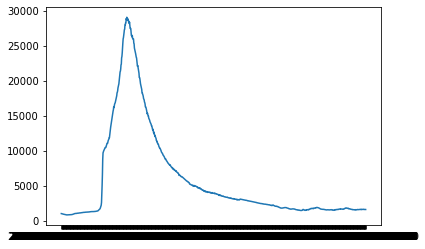

In [120]:
fig, ax = plt.subplots()
ax.plot(df["Dates"][:1000], df["Albright"][:1000])

In [121]:
df.isnull().sum()/len(df)

Albright    0.000000
Parsons     0.001399
DryFork     0.011251
Dates       0.000000
dtype: float64

In [122]:
len(df)

138657

In [123]:
df.dropna(inplace=True)

In [124]:
df.isna().sum()

Albright    0
Parsons     0
DryFork     0
Dates       0
dtype: int64

In [125]:
len(df)

137028

### Get sktime set up

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.datatypes import check_raise
from sktime.datatypes import convert
from sktime.datatypes import mtype
from sktime.datatypes import check_is_mtype

In [ ]:
df.drop("Dates", axis=1, inplace=True)

In [ ]:
df

In [ ]:
df.isna().sum()

In [ ]:
type(df)

In [ ]:
type(df.index)

In [ ]:
df.index = pd.PeriodIndex(df.index, freq="T")

In [ ]:
type(df.index)

In [ ]:
df.head()

In [ ]:
example = get_examples(mtype="pd.DataFrame", as_scitype="Series")[0]

In [ ]:
example

In [ ]:
type(example)

In [ ]:
type(example.index)

In [ ]:
df = df.reset_index()

In [ ]:
type(df.index)

In [ ]:
df.head()

In [ ]:
df.drop("Date", axis=1, inplace=True)

In [ ]:
df

In [ ]:
type(df.Albright)

In [ ]:
y = df

In [ ]:
forecaster.fit(y)

In [ ]:
y.drop(["Parsons", "DryFork"], axis=1, inplace=True)

In [ ]:
y.head()

In [ ]:
plot_series(y)

In [ ]:
forecaster.fit(y)

In [ ]:
fh = np.arange(1, 10000)
fh

In [ ]:
y_pred = forecaster.predict(fh)

In [ ]:
plot_series(y[136400:], y_pred, labels=["y", "y_pred"])

In [ ]:
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

In [ ]:


# optional: plotting predictions and past data
plot_series(y[136000:], y_pred, labels=["y", "y_pred"])



In [ ]:
y

In [ ]:
y["Parsons"] = df["Parsons"]

In [ ]:
y

In [ ]:
from sktime import DecisionTreeRegressor

In [ ]:
forecasters = [
    ("trend", PolynomialTrendForecaster(), 0),
    ("ses", ExponentialSmoothing(trend="add"), 1),
]

forecaster = ColumnEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()

In [ ]:
type(y)

In [ ]:


from sktime.datatypes import check_is_mtype


In [ ]:
type(a.index)

In [ ]:
type(y.index)

In [ ]:
type(a.a)

In [ ]:
type(y.Albright)

In [ ]:
mtype(y)

## Let's try using Kats... sktime is tough for me

In [ ]:
df.head()

In [ ]:
df.to_csv("for_kats.csv")

In [1]:
df = pd.read_csv("for_kats.csv")

NameError: name 'pd' is not defined

In [ ]:
df_ts = TimeSeriesData(time=df.Date, value=df[['Albright', 'Parsons', 'DryFork']], date_format="%Y%m%d %H%M%S")

In [ ]:
type(df_ts)

In [ ]:
df.Date

In [ ]:
df_ts[1:5] + df_ts[1:5]

In [ ]:
%matplotlib inline

df_ts.plot()

In [ ]:
df_ts.plot(cols=['Albright', 'Parsons'])

In [ ]:
type(df_ts)
df_ts